### 1. Install mmdetection

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

In [ ]:
# Install dependencies
%pip install -U openmim
!mim install "mmengine>=0.7.0"
!mim install "mmcv==2.1.0"

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git -b dev-3.x
%cd mmdetection
%pip install -v -e .

# Back to the root directory
%cd ..

In [6]:
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env

import mmdet

def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info

if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

sys.platform: win32
Python: 3.11.6 (tags/v3.11.6:8b6ee5b, Oct  2 2023, 14:57:12) [MSC v.1935 64 bit (AMD64)]
CUDA available: False
MUSA available: False
numpy_random_seed: 2147483648
MSVC: n/a, reason: fileno
PyTorch: 2.3.0+cpu
PyTorch compiling details: PyTorch built with:
  - C++ Version: 201703
  - MSVC 192930151
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.6 (Git Hash 86e6af5974177e513fd3fee58425e1063e7f1361)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX512
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CXX_COMPILER=C:/actions-runner/_work/pytorch/pytorch/builder/windows/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /Zc:__cplusplus /bigobj /FS /utf-8 -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DUSE_FBGEMM -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE /wd4624 /wd4068 /w

### 2. Train the model

In [ ]:
!python tools/train.py configs/pascal_voc/faster-rcnn.py      
!python tools/train.py configs/pascal_voc/yolov3.py      

### 3. Inference

#### 3.1 Generate bbox proposal after the first stage in Faster R-CNN

In [48]:
import warnings
from mmdet.apis import DetInferencer
warnings.filterwarnings("ignore")

# bbox proposal after the first stage 


# bbox after the second stage
rcnn_inferencer = DetInferencer(
    model='./configs/pascal_voc/faster-rcnn.py', 
    weights='./work_dirs/faster-rcnn/faster_rcnn.pth',
    device='cpu'
)
_ = rcnn_inferencer('./demo/in', out_dir='./src/in/second', no_save_pred=True)

Loads checkpoint by local backend from path: ./work_dirs/faster-rcnn/faster_rcnn.pth


Output()

#### 3.2 Compare the bbox after the first and second stage of Faster R-CNN

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

bbox_img_paths = ['./src/in/first/vis', './src/in/second/vis']
image_size = (1000, 600)

def get_image(path: str):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    return image

fig, axs = plt.subplots(4, 2, figsize=(15, 15))

for i in range(len(bbox_img_paths)):
    parent_dir = bbox_img_paths[i]
    children_path = os.listdir(parent_dir)
    for j, child in enumerate(children_path):
        axs[j, i].imshow(get_image(os.path.join(parent_dir, child)))
        axs[j, i].axis('off')
        if j == 0:
            axs[j, i].set_title(f'bbox after {parent_dir.split('/')[-2]} stage', fontsize=20)

plt.tight_layout()
plt.show()

#### 3.3 Generate bounding box for images out of the dataset

In [52]:
# inference for the Faster R-CNN
rcnn_inferencer = DetInferencer(
    model='./configs/pascal_voc/faster-rcnn.py', 
    weights='./work_dirs/faster-rcnn/faster_rcnn.pth',
    device='cpu'
)
_ = rcnn_inferencer('./demo/out', out_dir='./src/out/faster_rcnn', no_save_pred=True)

# inference for the yolov3
yolo_inferencer = DetInferencer(
    model='./configs/pascal_voc/yolov3.py',
    weights='./work_dirs/yolov3/yolov3.pth',
    device='cpu'
)
_ = yolo_inferencer('./demo/out', out_dir='./src/out/yolov3', no_save_pred=True)

Loads checkpoint by local backend from path: ./work_dirs/faster-rcnn/faster_rcnn.pth


Output()

Loads checkpoint by local backend from path: ./work_dirs/yolov3/yolov3.pth


Output()

#### 3.4 Compare the bbox results for one-stage and two stage detector

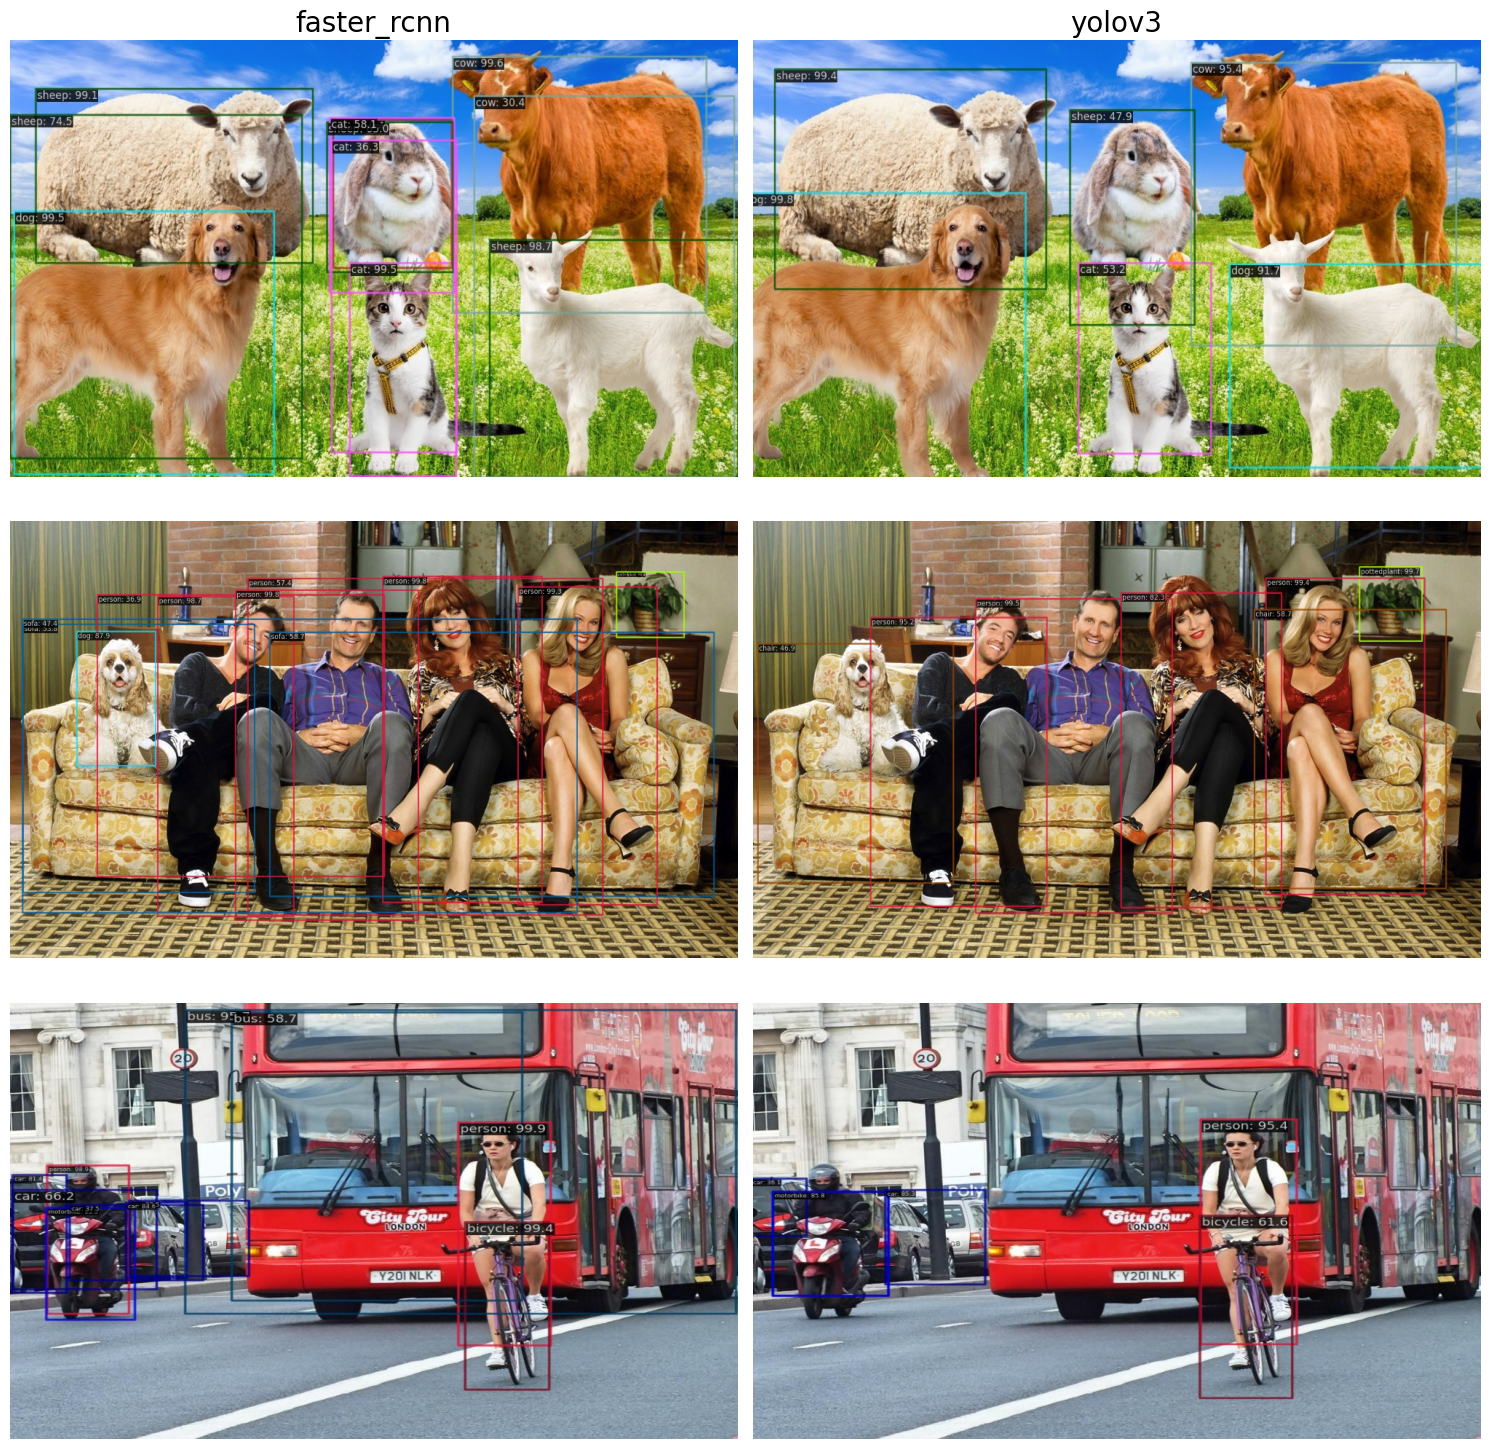

In [53]:
import os
import matplotlib.pyplot as plt
import cv2

bbox_img_paths = ['./src/out/faster_rcnn/vis', './src/out/yolov3/vis']
image_size = (1000, 600)

def get_image(path: str):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, image_size)
    return image

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i in range(len(bbox_img_paths)):
    parent_dir = bbox_img_paths[i]
    children_path = os.listdir(parent_dir)
    for j, child in enumerate(children_path):
        axs[j, i].imshow(get_image(os.path.join(parent_dir, child)))
        axs[j, i].axis('off')
        if j == 0:
            axs[j, i].set_title(parent_dir.split('/')[-2], fontsize=20)

plt.tight_layout()
plt.show()


In [34]:
import torch
from mmdet.apis import init_detector, inference_detector
from mmdet.apis.inference import build_test_pipeline
import mmcv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mmdet.models.detectors import FasterRCNN


# Configuration file and checkpoint file
config_file = './configs/pascal_voc/faster-rcnn_r50_fpn_1x_voc0712.py'
checkpoint_file = './work_dirs/faster-rcnn_r50_fpn_1x_voc0712/faster_rcnn.pth'

# Load config and model
model = init_detector(config_file, checkpoint_file, device='cpu')  # loading the model

Loads checkpoint by local backend from path: ./work_dirs/faster-rcnn_r50_fpn_1x_voc0712/faster_rcnn.pth
